# Generando recomendaciones de placement de farmacias

Utilizamos los datos de las farmacias del DENUE e información poblacional de censos en la localidad en donde se encuentran esas farmacias

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Preprocesamiento de datos

### Carga de archivos

In [203]:
farmacias = pd.read_csv('farmacias_censo.csv', sep=',', header=0, quotechar='"')

En este dataset, cada renglón es una farmacia y las columnas provienen de los datasets del DENUE y del Censo de 2020

In [204]:
farmacias

,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,tamloc
0,23279,01001433110000172000000000U8,ABASTECEDORA MEDICA HOSPITALARIA DE AGUASCALIE...,ABASTECEDORA MEDICA HOSPITALARIA DE AGUASCALIE...,464111,farmacias sin minisúper,11 a 30 personas,CALLE,GALEANA SUR,AVENIDA,...,232793.0,169675.0,123670.0,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0
1,8217258,01001464111004021000000000U3,BIOFARMACIA FAMILIAR,NaN,464111,farmacias sin minisúper,0 a 5 personas,CALLE,TENIENTE CORONEL ROBERTO JEFKINS RANGEL,CALLE,...,232793.0,169675.0,123670.0,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0
2,35681,01001464113000381000000000U1,BOTICA OMEOPATICA HAHANEMANN,NaN,464111,farmacias sin minisúper,0 a 5 personas,CALLE,NORBERTO GOMEZ HORNEDO,CALLE,...,232793.0,169675.0,123670.0,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0
3,6943828,01001464111003431000000000U5,CLUB DE NUTRICION,NaN,464111,farmacias sin minisúper,0 a 5 personas,CALLE,GALEANA SUR,CALLE,...,232793.0,169675.0,123670.0,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0
4,7162977,01001464111003271000000000U5,CLUB DE NUTRICION HERBA LIFE,NaN,464111,farmacias sin minisúper,0 a 5 personas,CALLE,ALONSO DE ALARCON,CALLE,...,232793.0,169675.0,123670.0,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65100,6416781,32010464112000202000019468S5,TIENDA FARMACIA NUMERO 8,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,464112,farmacias con minisúper,6 a 10 personas,AVENIDA,SONORA,CALLE,...,35906.0,25697.0,28951.0,7243.0,5278.0,543.0,1554.0,11481.0,193.0,11.0
65101,7447361,32020464111000421000000000U2,TIENDA NATURISTA YIREH,NaN,464111,farmacias sin minisúper,0 a 5 personas,PROLONGACION,FRANCISCO VILLA,CALLE,...,11935.0,8407.0,9464.0,2205.0,1503.0,235.0,644.0,4476.0,77.0,9.0
65102,7446632,32048464111000241000000000U5,TUFARMACIA,NaN,464111,farmacias sin minisúper,0 a 5 personas,AVENIDA,PRIMO VERDAD,CALLE,...,4788.0,2619.0,2160.0,703.0,400.0,227.0,265.0,2212.0,63.0,8.0
65103,7375868,32032464111000111000000000U4,VENTA DE HERVALIFE,NaN,464111,farmacias sin minisúper,0 a 5 personas,CALLE,HIDALGO,CALLE,...,922.0,336.0,636.0,56.0,47.0,12.0,108.0,691.0,4.0,5.0


In [205]:
farmacias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65105 entries, 0 to 65104
Columns: 326 entries, id to tamloc
dtypes: float64(286), int64(3), object(37)
memory usage: 161.9+ MB


In [206]:
farmacias.select_dtypes(include='int').columns

Index(['id', 'codigo_act', 'manzana'], dtype='object')

In [207]:
farmacias.select_dtypes(include='float').columns

Index(['numero_ext', 'edificio_e', 'numero_int', 'cod_postal', 'telefono',
       'entidad.y', 'mun', 'loc', 'altitud', 'pobtot',
       ...
       'vph_cel', 'vph_inter', 'vph_stvp', 'vph_spmvpi', 'vph_cvj',
       'vph_sinrtv', 'vph_sinltc', 'vph_sincint', 'vph_sintic', 'tamloc'],
      dtype='object', length=286)

In [208]:
farmacias.select_dtypes(include='object').columns

Index(['clee', 'nom_estab', 'raz_social', 'nombre_act', 'per_ocu', 'tipo_vial',
       'nom_vial', 'tipo_v_e_1', 'nom_v_e_1', 'tipo_v_e_2', 'nom_v_e_2',
       'tipo_v_e_3', 'nom_v_e_3', 'letra_ext', 'edificio', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local',
       'entidad.x', 'municipio', 'localidad', 'ageb', 'correoelec', 'www',
       'tipoUniEco', 'fecha_alta', 'geometryI', 'geometryII', 'id_loc',
       'nom_ent', 'nom_mun', 'nom_loc', 'longitud', 'latitud'],
      dtype='object')

Hacemos un poco de limpieza...

In [209]:
# Tiramos la columna sobre la cual realizamos el join
farmacias.rename(columns={'entidad.x': 'entidad'}, inplace=True)
farmacias = farmacias.drop(columns=['entidad.y'])

In [210]:
# Corregimos un error inducido por la "," presente en la columna geometry
farmacias['geometry'] = farmacias['geometryI'].astype(str) + ', ' + farmacias['geometryII'].astype(str)
farmacias = farmacias.drop(columns=['geometryI', 'geometryII'])

In [211]:
farmacias['geometry']

0        c(-30492.1819804115, 1095515.78460615)
1        c(-25698.4442870239, 1099806.51189031)
2         c(-30034.074999398, 1097491.02593047)
3        c(-30496.4297441311, 1095564.62596806)
4        c(-26563.0042685416, 1101454.41658362)
                          ...                  
65100    c(-89223.9680617652, 1238783.64778009)
65101    c(-101039.779420174, 1180801.00976333)
65102     c(-134138.576864361, 1085854.4709932)
65103    c(-62174.4087592916, 1200206.62886475)
65104    c(-78207.8702810948, 1177464.13295567)
Name: geometry, Length: 65105, dtype: object

Y manejamos valores nulos:

In [212]:
farmacias.isna().sum().unique()

array([    0,     1, 43516,   160,  1520,   879,  1536,   876,  1952,
         928, 16111, 33442, 63254, 63099, 48389, 62447,   103,     7,
       63477, 63350, 63363,   391, 49200, 44593, 52482,    59,    69])

Tiremos aquellas columnas con muchos valores nulos (digamos, mayor a 103)

In [213]:
farmacias.shape[1]

324

In [214]:
farmacias = farmacias.loc[:, farmacias.isna().sum() < 104]


In [215]:
farmacias.shape[1]

303

In [216]:
farmacias.isna().sum()

id              0
clee            0
nom_estab       1
codigo_act      0
nombre_act      0
               ..
vph_sinltc     69
vph_sincint    69
vph_sintic     69
tamloc         59
geometry        0
Length: 303, dtype: int64

Y para los restantes valores nulos, tiramos aquellos renglones donde ocurran, pues son pocos comparados al dataset entero.

In [217]:
farmacias.shape[0]

65105

In [218]:
farmacias = farmacias.dropna()

In [219]:
farmacias.shape[0]

64931

Finalmente, agregamos una columna o variable target **y**, la cual representará si la farmacia lleva abierta más de **n** años (1) o no (0). Para determinar n, veamos cómo se distribuyen los años en la columna "fecha_alta"

In [220]:
farmacias['fecha_alta']

0        2010-07
1        2019-11
2        2014-12
3        2019-11
4        2019-11
          ...   
65100    2010-07
65101    2019-11
65102    2019-11
65103    2019-11
65104    2010-07
Name: fecha_alta, Length: 64931, dtype: object

In [221]:
# Convertimos object a date
farmacias['fecha_alta'] = pd.to_datetime(farmacias['fecha_alta'], format='%Y-%m', errors='coerce')

In [222]:
farmacias['fecha_alta']

0       2010-07-01
1       2019-11-01
2       2014-12-01
3       2019-11-01
4       2019-11-01
           ...    
65100   2010-07-01
65101   2019-11-01
65102   2019-11-01
65103   2019-11-01
65104   2010-07-01
Name: fecha_alta, Length: 64931, dtype: datetime64[ns]

In [223]:
farmacias['fecha_alta'].isna().sum()

np.int64(28)

Hubieron 28 fechas mal formateadas. Nos podemos dar el lujo de tirar estos renglones.

In [224]:
print(farmacias.shape[0])
farmacias.dropna(subset=['fecha_alta'], inplace=True)
print(farmacias.shape[0])

64931
64903


Ahora sí, veamos la distribución con respecto a los años

In [228]:
# Extract the year from the datetime column
farmacias['anio_alta'] = farmacias['fecha_alta'].dt.year

In [229]:
farmacias['anio_alta']

0        2010
1        2019
2        2014
3        2019
4        2019
         ... 
65100    2010
65101    2019
65102    2019
65103    2019
65104    2010
Name: anio_alta, Length: 64903, dtype: int32

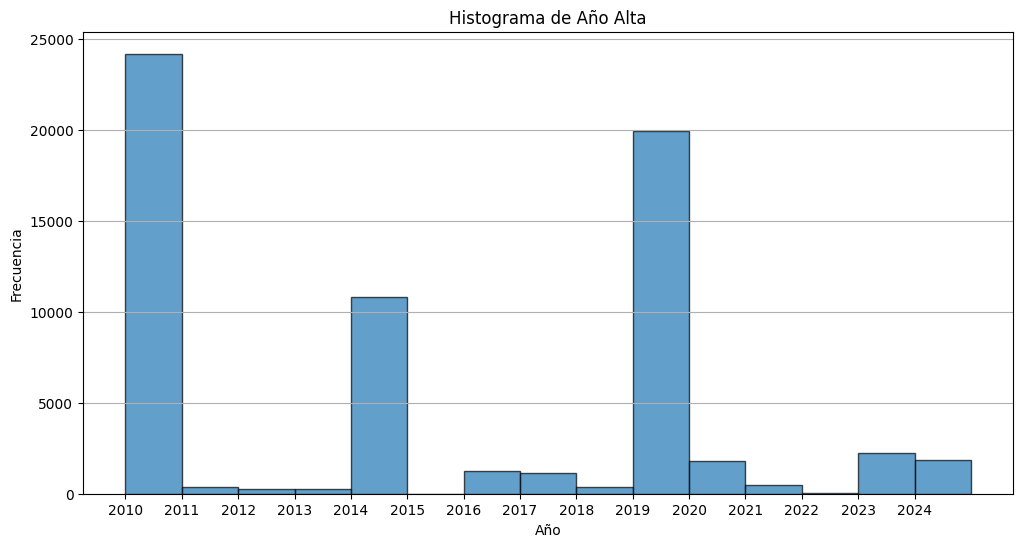

In [241]:
# Plotting the histogram
plt.figure(figsize=(12, 6)) 
plt.hist(farmacias['anio_alta'].dropna(), bins=range(farmacias['anio_alta'].min(), farmacias['anio_alta'].max() + 2), edgecolor='black', alpha=0.7)
plt.xticks(range(farmacias['anio_alta'].min(), farmacias['anio_alta'].max() + 1))  # Set x-ticks to the years
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.title('Histograma de Año Alta')
plt.grid(axis='y')
plt.show()

Vemos que hay mucha variabilidad en estos datos. Digamos entonces que **n** = 6 y establezcamos nuestra columna target **y**

In [242]:
farmacias['y'] = np.where(farmacias['anio_alta'] < 2018, 1, 0)
farmacias

,id,clee,nom_estab,codigo_act,nombre_act,per_ocu,nom_vial,tipo_asent,nomb_asent,entidad,...,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,tamloc,geometry,anio_alta,y
0,23279,01001433110000172000000000U8,ABASTECEDORA MEDICA HOSPITALARIA DE AGUASCALIE...,464111,farmacias sin minisúper,11 a 30 personas,GALEANA SUR,COLONIA,OBRAJE,Aguascalientes,...,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0,"c(-30492.1819804115, 1095515.78460615)",2010,1
1,8217258,01001464111004021000000000U3,BIOFARMACIA FAMILIAR,464111,farmacias sin minisúper,0 a 5 personas,TENIENTE CORONEL ROBERTO JEFKINS RANGEL,FRACCIONAMIENTO,LIC BENITO PALOMINO DENA,Aguascalientes,...,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0,"c(-25698.4442870239, 1099806.51189031)",2019,0
2,35681,01001464113000381000000000U1,BOTICA OMEOPATICA HAHANEMANN,464111,farmacias sin minisúper,0 a 5 personas,NORBERTO GOMEZ HORNEDO,COLONIA,GREMIAL,Aguascalientes,...,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0,"c(-30034.074999398, 1097491.02593047)",2014,1
3,6943828,01001464111003431000000000U5,CLUB DE NUTRICION,464111,farmacias sin minisúper,0 a 5 personas,GALEANA SUR,COLONIA,OBRAJE,Aguascalientes,...,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0,"c(-30496.4297441311, 1095564.62596806)",2019,0
4,7162977,01001464111003271000000000U5,CLUB DE NUTRICION HERBA LIFE,464111,farmacias sin minisúper,0 a 5 personas,ALONSO DE ALARCON,FRACCIONAMIENTO,VILLAS DE NUESTRA SEÑORA DE LA ASUNCION (SECTO...,Aguascalientes,...,77719.0,53589.0,2995.0,5984.0,63661.0,595.0,13.0,"c(-26563.0042685416, 1101454.41658362)",2019,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65100,6416781,32010464112000202000019468S5,TIENDA FARMACIA NUMERO 8,464112,farmacias con minisúper,6 a 10 personas,SONORA,SECTOR,LAGUNILLA,Zacatecas,...,7243.0,5278.0,543.0,1554.0,11481.0,193.0,11.0,"c(-89223.9680617652, 1238783.64778009)",2010,1
65101,7447361,32020464111000421000000000U2,TIENDA NATURISTA YIREH,464111,farmacias sin minisúper,0 a 5 personas,FRANCISCO VILLA,COLONIA,JEREZ CENTRO,Zacatecas,...,2205.0,1503.0,235.0,644.0,4476.0,77.0,9.0,"c(-101039.779420174, 1180801.00976333)",2019,0
65102,7446632,32048464111000241000000000U5,TUFARMACIA,464111,farmacias sin minisúper,0 a 5 personas,PRIMO VERDAD,BARRIO,SAN DIEGO,Zacatecas,...,703.0,400.0,227.0,265.0,2212.0,63.0,8.0,"c(-134138.576864361, 1085854.4709932)",2019,0
65103,7375868,32032464111000111000000000U4,VENTA DE HERVALIFE,464111,farmacias sin minisúper,0 a 5 personas,HIDALGO,LOCALIDAD,HACIENDA NUEVA,Zacatecas,...,56.0,47.0,12.0,108.0,691.0,4.0,5.0,"c(-62174.4087592916, 1200206.62886475)",2019,0


## Análisis Exploratorio

Ya con un target, podemos graficar una matriz de correlación para ver que variables **numéricas** contribuyen a que la farmacia lleve abierta más de 6 años.

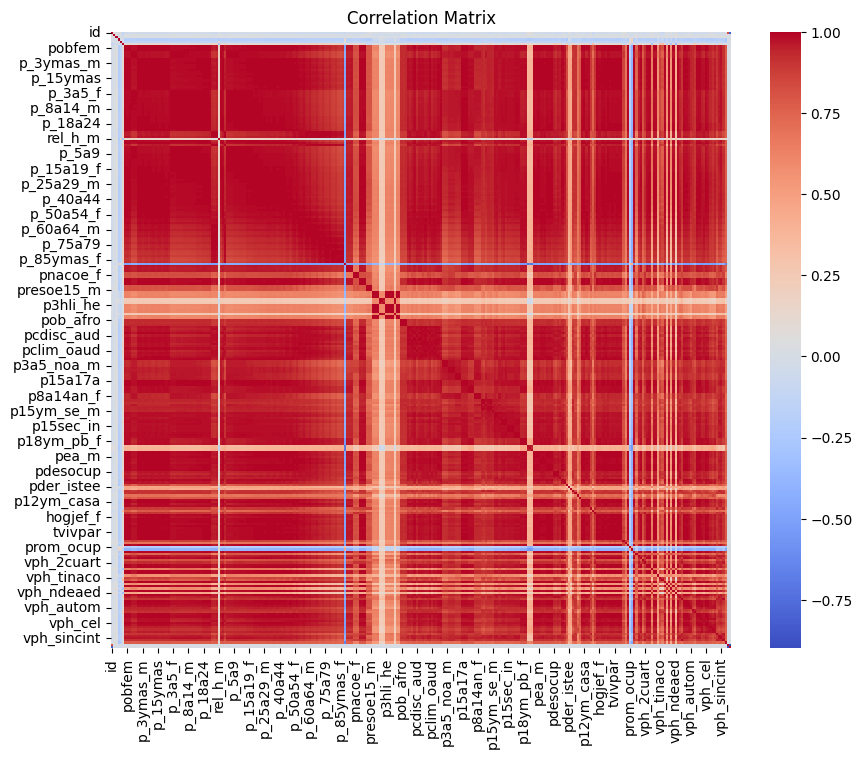

In [244]:
# Matriz de correlación entre todas las variables numéricas de nuestro dataframe
correlation_matrix = farmacias.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [266]:
correlation_with_y = correlation_matrix['y']
correlation_with_y

id            -0.817978
codigo_act     0.034800
manzana       -0.030056
mun           -0.008929
loc           -0.027803
                 ...   
vph_sincint    0.017742
vph_sintic     0.008980
tamloc         0.006046
anio_alta     -0.898181
y              1.000000
Name: y, Length: 285, dtype: float64

Veamos las correlaciones más altas:

In [271]:
correlation_with_y = correlation_with_y.drop('y')
top_corrs = correlation_with_y.nlargest(40)
print(top_corrs)

p_85ymas_f     0.037281
p_85ymas       0.037175
p_85ymas_m     0.036895
vph_cister     0.035915
p_80a84_f      0.035593
p_80a84        0.035312
p_80a84_m      0.034843
codigo_act     0.034800
p_75a79_f      0.034138
p_75a79        0.033601
p_75a79_m      0.032864
p_70a74_f      0.032825
pob65_mas      0.032501
p_70a74        0.032211
potras_rel     0.032162
p_60ymas_f     0.031821
p_70a74_m      0.031399
p_60ymas       0.031124
p_65a69_f      0.030468
p_60ymas_m     0.030204
p_65a69        0.029806
pcdisc_aud     0.029633
p_65a69_m      0.028966
vph_telef      0.028932
p_60a64_f      0.028836
pcdisc_mot     0.028661
pclim_oaud     0.028502
p_60a64        0.028087
pclim_csb      0.027689
p_60a64_m      0.027158
pclim_mot2     0.026840
vph_bici       0.026803
p_55a59_f      0.026547
vph_tinaco     0.026541
p12ym_sepa     0.026358
pcon_disc      0.026292
pcdisc_mot2    0.026138
pdesocup_f     0.026096
p_55a59        0.025786
pclim_re_co    0.025773
Name: y, dtype: float64


De aquí, aparte de una correlación esperada con respecto a la edad de la población (mayor a 60) de la localidad de la farmacia, vemos que también las variables (vph_cister, potras_rel, pcdisc_aud, vph_telef, pcdisc_mot, pclim_oaud, pclim_csb, pclim_mot2, vph_bici, vph_tinaco, p12ym_sepa, pcon_disc, pcdisc_mot2, pdesocup_f, pclim_re_co) se correlacionan positivamente con que la farmacia lleve abierta más de 6 años (de manera mayor al 25%).

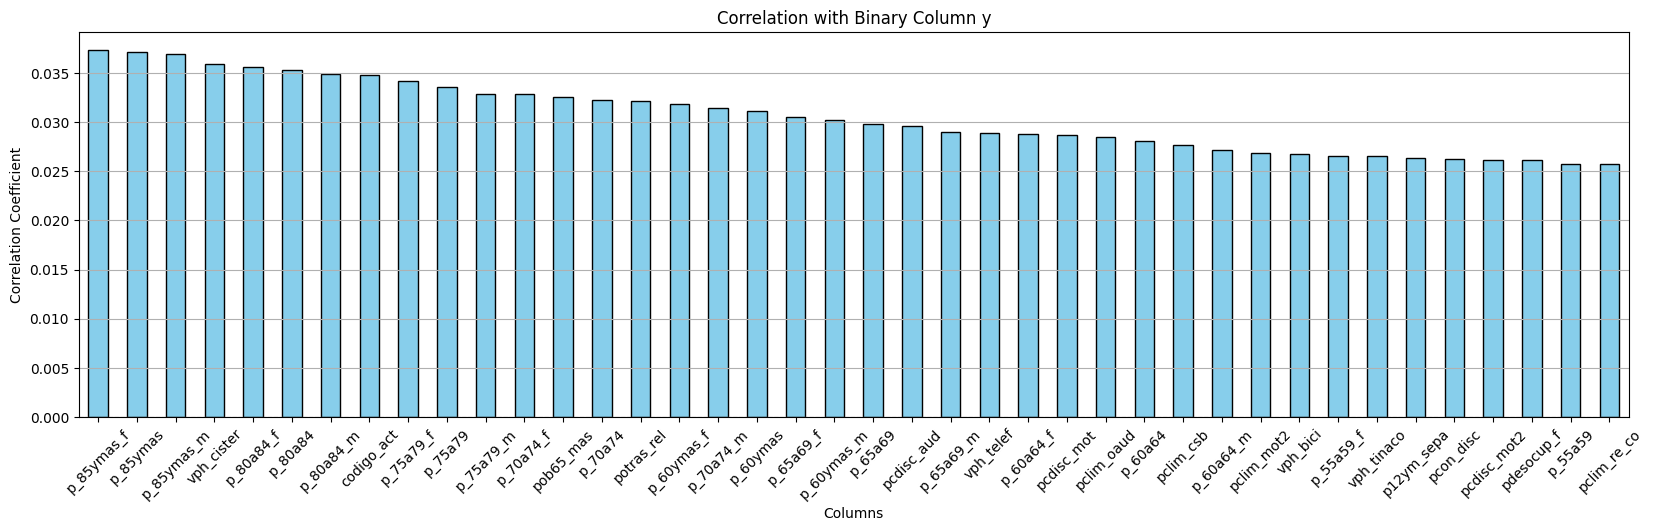

In [272]:
# Plotting the correlation with 'y'
plt.figure(figsize=(20, 5))
top_corrs.plot(kind='bar', color='skyblue', edgecolor='black')  # Drop 'y' to avoid self-correlation
plt.title('Correlation with Binary Column y')
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a line at y=0 for reference
plt.grid(axis='y')
plt.show()

A su vez, podemos ver qué variables se correlacionan negativamente con que la farmacia lleve abierta más de 6 años.

In [275]:
correlation_with_y = correlation_with_y.drop('anio_alta')
correlation_with_y = correlation_with_y.drop('id')
low_corrs = correlation_with_y.nsmallest(20)
print(low_corrs)

pro_ocup_c   -0.033061
manzana      -0.030056
loc          -0.027803
prom_ocup    -0.025470
rel_h_m      -0.019315
vph_ndeaed   -0.019005
vph_nodren   -0.018351
p5_hli_nhe   -0.016218
p3hlinhe_f   -0.016210
p3hlinhe     -0.016065
p3hlinhe_m   -0.015271
vph_letr     -0.013442
vph_s_elec   -0.012893
pder_istee   -0.012739
graproes     -0.011115
graproes_m   -0.009014
mun          -0.008929
p3hli_he_m   -0.008591
p3ym_hli_m   -0.008448
graproes_f   -0.008089
Name: y, dtype: float64


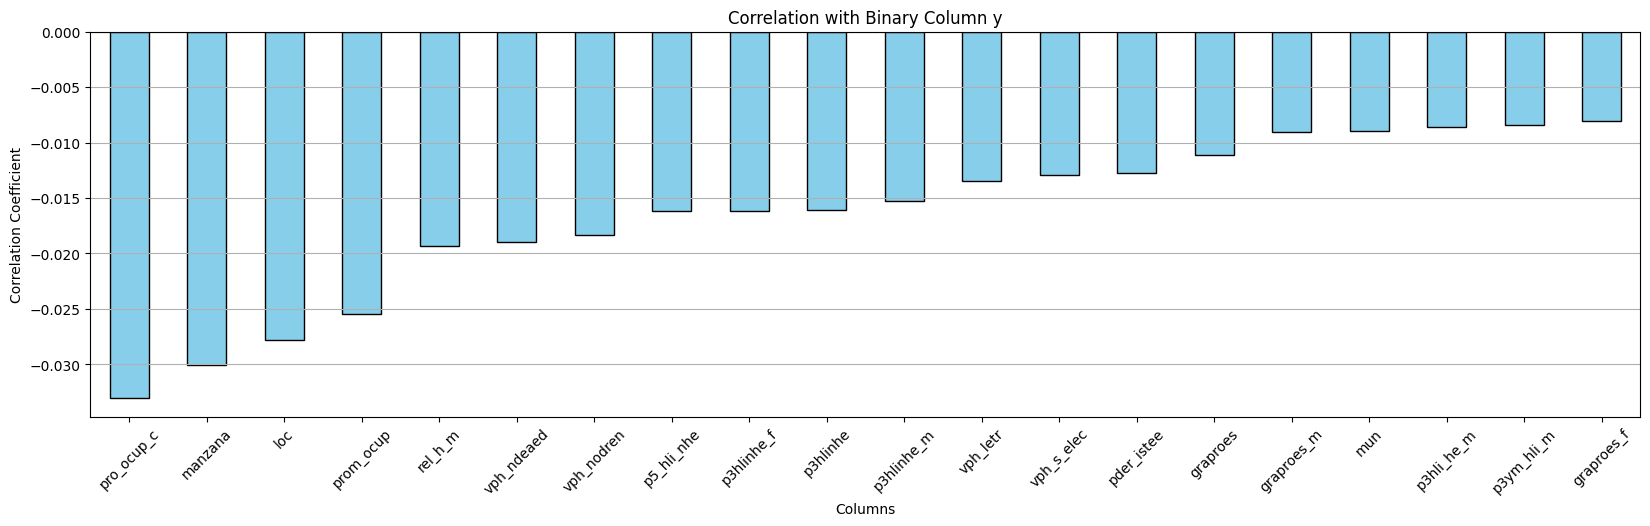

In [276]:
# Plotting the correlation with 'y'
plt.figure(figsize=(20, 5))
low_corrs.plot(kind='bar', color='skyblue', edgecolor='black')  # Drop 'y' to avoid self-correlation
plt.title('Correlation with Binary Column y')
plt.xlabel('Columns')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a line at y=0 for reference
plt.grid(axis='y')
plt.show()

## Recomendando placements

Del análisis de correlación contra tiempo de apertura mayor a 6 años, podemos ahora seleccionar 4 variables correlacionadas positivamente (y 4 variables correlacionadas negativamente) para recomendar (o no) localidades donde colocar farmacias. 

**Variables correlacionadas positivamente elegidas:**
- Viviendas particulares habitadas que disponen de cisterna o aljibe, correlación del 3.5% (vph_cister)
- Población con otras religiones diferentes a las anteriores, correlación del 3.2% (potras_rel)
- Población de 60 años y más, correlación del 3% (p_60ymas)
- Población con discapacidad para oír, aun usando aparato auditivo, correlación del 2.9% (pcdisc_aud)

**Variables correlacionadas negativamente elegidas:**
- Promedio de ocupantes por cuarto en viviendas particulares habitadas, correlación del -3.3% (pro_ocup_c)
- Relación hombres-mujeres, correlación del -1.9% (rel_h_m)
- Viviendas particulares habitadas que no disponen de energía eléctrica, agua entubada, ni drenaje, correlación del -1.9% (vph_ndeaed)
- Población de 5 años y más que habla alguna lengua indígena y no habla español. correlación del -1.6% (p5_hli_nhe)

Seleccionemos las 200 localidades donde los valores de las correlaciones son mayores y positivas (haríamos lo análogo para las variables con correlación negativa).

In [291]:
censo = pd.read_csv('conjunto_de_datos_iter_00CSV20.csv')

/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_20096/1019247984.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  censo = pd.read_csv('conjunto_de_datos_iter_00CSV20.csv')


In [292]:
# Get the rows where the values in columns vph_cister, potras_rel, p_60ymas, and pcdisc_aud are the highest
n = 200  # number of top rows to get

a = 'vph_cister'.upper()
b = 'potras_rel'.upper()
c = 'p_60ymas'.upper()
d = 'pcdisc_aud'.upper()

# Convertimos a números y hacemos un coerce de errores a 0
censo[a] = pd.to_numeric(censo[a], errors='coerce').fillna(0)
censo[b] = pd.to_numeric(censo[b], errors='coerce').fillna(0)
censo[c] = pd.to_numeric(censo[c], errors='coerce').fillna(0)
censo[d] = pd.to_numeric(censo[d], errors='coerce').fillna(0)

# Get the top n rows for each column and combine them
top_a = censo.nlargest(n, a)
top_b = censo.nlargest(n, b)
top_c = censo.nlargest(n, c)
top_d = censo.nlargest(n, d)

# Combine the results and drop duplicates if necessary
localidades_recomendadas = pd.concat([top_a, top_b, top_c, top_d]).drop_duplicates()

In [293]:
localidades_recomendadas

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
0,0,Total nacional,0,Total nacional,0,Total nacional,NaN,NaN,NaN,126014024,...,30775898,18307193,15211306,6616141,4047100,1788552,3170894,15108204,852871,*
90521,15,México,0,Total de la entidad México,0,Total de la Entidad,NaN,NaN,NaN,16992418,...,4049493,2561525,1559564,822048,572663,133777,329132,1769551,53857,*
52272,9,Ciudad de México,0,Total de la entidad Ciudad de México,0,Total de la Entidad,NaN,NaN,NaN,9209944,...,2536523,2084156,1290811,957162,568827,46172,77272,561128,10528,*
79806,14,Jalisco,0,Total de la entidad Jalisco,0,Total de la Entidad,NaN,NaN,NaN,8348151,...,2134429,1437473,1199700,573528,375678,56399,96948,760439,17553,*
126034,21,Puebla,0,Total de la entidad Puebla,0,Total de la Entidad,NaN,NaN,NaN,6583278,...,1444126,691363,539920,213909,129993,102541,207818,939937,49800,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134986,22,Querétaro,16,San Juan del Río,0,Total del Municipio,NaN,NaN,NaN,297804,...,76057,43246,32549,14083,8961,2420,5407,34978,730,*
157729,27,Tabasco,2,Cárdenas,0,Total del Municipio,NaN,NaN,NaN,243229,...,57481,18978,39438,4389,1882,6061,9162,45291,2791,*
179112,30,Veracruz de Ignacio de la Llave,124,Papantla,0,Total del Municipio,NaN,NaN,NaN,159910,...,34917,15449,15072,2244,1214,2947,8549,28536,1645,*
111470,19,Nuevo León,21,General Escobedo,1,Ciudad General Escobedo,"100°19'21.510"" W","25°48'28.750"" N",500.0,454967,...,117986,89129,60214,38231,25711,2299,3549,31061,592,12


Note que tenemos que remover aquellos renglones donde se registran totales. Volvamoslo a hacer para tener nuestras recomendaciones finales

In [294]:
# Define the unwanted value
unwanted_value = 'Total'

# Filter the DataFrame to exclude rows with the unwanted value in column 'x'
censo = censo[~censo['NOM_MUN'].str.contains(unwanted_value)]
censo = censo[~censo['NOM_LOC'].str.contains(unwanted_value)]

# Get the rows where the values in columns vph_cister, potras_rel, p_60ymas, and pcdisc_aud are the highest
n = 200  # number of top rows to get

a = 'vph_cister'.upper()
b = 'potras_rel'.upper()
c = 'p_60ymas'.upper()
d = 'pcdisc_aud'.upper()

# Convertimos a números y hacemos un coerce de errores a 0
censo[a] = pd.to_numeric(censo[a], errors='coerce').fillna(0)
censo[b] = pd.to_numeric(censo[b], errors='coerce').fillna(0)
censo[c] = pd.to_numeric(censo[c], errors='coerce').fillna(0)
censo[d] = pd.to_numeric(censo[d], errors='coerce').fillna(0)

# Get the top n rows for each column and combine them
top_a = censo.nlargest(n, a)
top_b = censo.nlargest(n, b)
top_c = censo.nlargest(n, c)
top_d = censo.nlargest(n, d)

# Combine the results and drop duplicates if necessary
localidades_recomendadas = pd.concat([top_a, top_b, top_c, top_d]).drop_duplicates()

In [295]:
localidades_recomendadas

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
52311,9,Ciudad de México,7,Iztapalapa,1,Iztapalapa,"99°05'33.441"" W","19°21'32.414"" N",2239.0,1835486,...,455216,349103,183804,116462,82472,9371,18791,132846,2489,14
129890,21,Puebla,114,Puebla,1,Heroica Puebla de Zaragoza,"98°11'50.981"" W","19°02'38.363"" N",2137.0,1542232,...,409277,293163,180746,113497,67255,8926,15683,124400,2012,14
89906,14,Jalisco,120,Zapopan,1,Zapopan,"103°23'20.356"" W","20°43'15.463"" N",1577.0,1257547,...,338888,281051,182738,153816,91651,5069,7184,62151,918,14
91716,15,México,33,Ecatepec de Morelos,1,Ecatepec de Morelos,"99°02'56.971"" W","19°35'56.650"" N",2259.0,1643623,...,401122,290432,151628,86775,63620,8344,19692,134765,2528,14
92583,15,México,58,Nezahualcóyotl,1,Ciudad Nezahualcóyotl,"99°01'05.520"" W","19°24'31.548"" N",2262.0,1072676,...,265642,204588,92213,60342,42184,5493,13623,80290,1620,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190234,31,Yucatán,96,Tizimín,1,Tizimín,"88°09'08.158"" W","21°08'36.683"" N",20.0,52593,...,11939,5049,6922,1029,486,776,1676,7764,330,10
61285,11,Guanajuato,14,Dolores Hidalgo Cuna de la Independencia Nacional,1,Dolores Hidalgo Cuna de la Independencia Nacional,"100°55'02.048"" W","21°09'33.121"" N",1932.0,67101,...,15325,11549,12475,2845,1799,395,666,4452,123,10
192557,32,Zacatecas,20,Jerez,1,Jerez de García Salinas,"102°59'23.725"" W","22°38'57.852"" N",1999.0,46132,...,11935,8407,9464,2205,1503,235,644,4476,77,9
115585,20,Oaxaca,44,Loma Bonita,1,Loma Bonita,"95°52'47.914"" W","18°06'35.536"" N",25.0,31469,...,8513,3606,4001,661,278,933,1139,5972,312,9


Al final, tuvimos intersección entre las localidades donde ocurren de manera alta las variables que elegimos. Quedémonnos con las primeras 200.

Estas son nuestras localidades recomendadas.

In [296]:
localidades_recomendadas = localidades_recomendadas.head(200)
localidades_recomendadas

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
52311,9,Ciudad de México,7,Iztapalapa,1,Iztapalapa,"99°05'33.441"" W","19°21'32.414"" N",2239.0,1835486,...,455216,349103,183804,116462,82472,9371,18791,132846,2489,14
129890,21,Puebla,114,Puebla,1,Heroica Puebla de Zaragoza,"98°11'50.981"" W","19°02'38.363"" N",2137.0,1542232,...,409277,293163,180746,113497,67255,8926,15683,124400,2012,14
89906,14,Jalisco,120,Zapopan,1,Zapopan,"103°23'20.356"" W","20°43'15.463"" N",1577.0,1257547,...,338888,281051,182738,153816,91651,5069,7184,62151,918,14
91716,15,México,33,Ecatepec de Morelos,1,Ecatepec de Morelos,"99°02'56.971"" W","19°35'56.650"" N",2259.0,1643623,...,401122,290432,151628,86775,63620,8344,19692,134765,2528,14
92583,15,México,58,Nezahualcóyotl,1,Ciudad Nezahualcóyotl,"99°01'05.520"" W","19°24'31.548"" N",2262.0,1072676,...,265642,204588,92213,60342,42184,5493,13623,80290,1620,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166739,29,Tlaxcala,6,Calpulalpan,1,Heroica Ciudad de Calpulalpan,"98°34'13.712"" W","19°35'18.693"" N",2591.0,37704,...,8507,3727,5237,767,621,204,736,5150,69,9
88109,14,Jalisco,94,Tequila,1,Tequila,"103°50'08.328"" W","20°52'45.982"" N",1201.0,31115,...,7264,4937,5530,1453,1016,219,281,2539,49,9
67588,11,Guanajuato,44,Villagrán,1,Villagrán,"100°59'47.410"" W","20°30'40.938"" N",1731,28109,...,6260,3370,2997,877,627,143,473,3229,55,8
72604,12,Guerrero,55,Taxco de Alarcón,1,Taxco de Alarcón,"99°36'16.541"" W","18°33'26.575"" N",1752,50399,...,13038,7537,7095,1391,1044,442,790,6495,122,10


In [297]:
localidades_recomendadas.to_csv('localidades_recomendadas_dataframe.csv', index=False)